## Mnist卷积神经网络示例   TensorFlow2.0版本

In [1]:
import numpy as np
import tensorflow.keras as ka
import datetime

In [2]:
np.random.seed(0)
 
(X_train, y_train), (X_val, y_val) = ka.datasets.mnist.load_data("E:\datasets\MNIST_Data\mnist.npz") 

In [3]:
# 将数组转换成卷积层需要的格式
X_train = X_train.reshape(X_train.shape[0],28, 28, 1).astype('float32')
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1).astype('float32')

In [4]:
X_train = X_train / 255
X_val = X_val / 255
 
y_train = ka.utils.to_categorical(y_train) # 转化为独热编码
y_val = ka.utils.to_categorical(y_val)
num_classes = y_val.shape[1] # 10

In [5]:
# CNN模型
model = ka.Sequential([
    ka.layers.Conv2D(filters=32, kernel_size=(5, 5), input_shape=(28, 28, 1), activation='relu'),
    ka.layers.MaxPooling2D(pool_size=(2, 2)),
    ka.layers.Dropout(0.2),
    ka.layers.BatchNormalization(),
    ka.layers.Flatten(),
    ka.layers.Dense(128, activation='relu'),
    ka.layers.Dense(num_classes, activation='softmax')
])
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

startdate = datetime.datetime.now() # 获取当前时间
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=2, batch_size=200, verbose=2)
enddate = datetime.datetime.now()
print("训练用时：" + str(enddate - startdate))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 12, 32)        128       
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               589952    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

## Mnist卷积神经网络示例   MindSpore版本

In [6]:
import os
import mindspore.dataset as ds
import mindspore.nn as nn
from mindspore import Model
from mindspore.common.initializer import Normal
from mindspore.train.callback import LossMonitor
import mindspore.dataset.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C
from mindspore.nn.metrics import Accuracy
from mindspore import dtype as mstype
from mindspore.nn import SoftmaxCrossEntropyWithLogits

def create_dataset(data_path, batch_size=32, repeat_size=1, num_parallel_workers=1):
    # 从mnist文件中产生数据集

    mnist_ds = ds.MnistDataset(data_path)

    rescale = 1.0 / 255.0 # 归一化比例
    shift = 0.0
    rescale_nml = 1 / 0.3081
    shift_nml = -1 * 0.1307 / 0.3081

    # map 算子
    rescale_nml_op = CV.Rescale(rescale_nml, shift_nml) 
    rescale_op = CV.Rescale(rescale, shift) 
    hwc2chw_op = CV.HWC2CHW() # (height, width, channel) -> (channel, height, width)
    type_cast_op = C.TypeCast(mstype.int32) 

    mnist_ds = mnist_ds.map(operations=type_cast_op, input_columns="label", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=rescale_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=rescale_nml_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=hwc2chw_op, input_columns="image", num_parallel_workers=num_parallel_workers)

    buffer_size = 10000
    mnist_ds = mnist_ds.shuffle(buffer_size=buffer_size)
    mnist_ds = mnist_ds.batch(batch_size, drop_remainder=True)
    mnist_ds = mnist_ds.repeat(repeat_size)

    return mnist_ds


class CNNNet(nn.Cell):
    def __init__(self, num_class=10, num_channel=1):
        super(CNNNet, self).__init__()
        self.conv = nn.Conv2d(num_channel, 32, 5, pad_mode='valid', has_bias=True)
        self.fc1 = nn.Dense(32 * 12 * 12, 128, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(128, num_class, weight_init=Normal(0.02))
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(keep_prob=0.8)
        self.bn = nn.BatchNorm2d(num_features=32)
        self.softmax = nn.Softmax()

    def construct(self, x):
        x = self.relu(self.conv(x))
        x = self.max_pool2d(x)
        x = self.dropout(x)
        x = self.bn(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

In [7]:
lr = 0.01
momentum = 0.9
dataset_size = 1
mnist_path = "E:\datasets\MNIST_Data"
net_loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
train_epoch = 2
net = CNNNet()
net_opt = nn.Momentum(net.trainable_params(), lr, momentum)
ms_model = Model(net, net_loss, net_opt, metrics={"Accuracy": Accuracy()})
ds_train = create_dataset(os.path.join(mnist_path, "train"), 200, dataset_size)
startdate = datetime.datetime.now() # 获取当前时间
ms_model.train(train_epoch, ds_train, callbacks=[LossMonitor()], dataset_sink_mode=False)
enddate = datetime.datetime.now()
print("训练用时：" + str(enddate - startdate))

epoch: 1 step: 1, loss is 2.306879758834839
epoch: 1 step: 2, loss is 2.3053345680236816
epoch: 1 step: 3, loss is 2.3051085472106934
epoch: 1 step: 4, loss is 2.3031442165374756
epoch: 1 step: 5, loss is 2.2971389293670654
epoch: 1 step: 6, loss is 2.299102544784546
epoch: 1 step: 7, loss is 2.2929129600524902
epoch: 1 step: 8, loss is 2.2933902740478516
epoch: 1 step: 9, loss is 2.292130947113037
epoch: 1 step: 10, loss is 2.2908709049224854
epoch: 1 step: 11, loss is 2.2877907752990723
epoch: 1 step: 12, loss is 2.2828176021575928
epoch: 1 step: 13, loss is 2.283750534057617
epoch: 1 step: 14, loss is 2.2832648754119873
epoch: 1 step: 15, loss is 2.2768914699554443
epoch: 1 step: 16, loss is 2.276449203491211
epoch: 1 step: 17, loss is 2.2712907791137695
epoch: 1 step: 18, loss is 2.272109270095825
epoch: 1 step: 19, loss is 2.261559247970581
epoch: 1 step: 20, loss is 2.2695748805999756
epoch: 1 step: 21, loss is 2.254854202270508
epoch: 1 step: 22, loss is 2.2554290294647217
epoch

epoch: 1 step: 179, loss is 1.5348031520843506
epoch: 1 step: 180, loss is 1.5268157720565796
epoch: 1 step: 181, loss is 1.541986346244812
epoch: 1 step: 182, loss is 1.5369704961776733
epoch: 1 step: 183, loss is 1.5209919214248657
epoch: 1 step: 184, loss is 1.5595004558563232
epoch: 1 step: 185, loss is 1.529340386390686
epoch: 1 step: 186, loss is 1.5394821166992188
epoch: 1 step: 187, loss is 1.5477228164672852
epoch: 1 step: 188, loss is 1.5425217151641846
epoch: 1 step: 189, loss is 1.5426937341690063
epoch: 1 step: 190, loss is 1.5581979751586914
epoch: 1 step: 191, loss is 1.5450499057769775
epoch: 1 step: 192, loss is 1.5572526454925537
epoch: 1 step: 193, loss is 1.5470175743103027
epoch: 1 step: 194, loss is 1.5408997535705566
epoch: 1 step: 195, loss is 1.5356476306915283
epoch: 1 step: 196, loss is 1.5175281763076782
epoch: 1 step: 197, loss is 1.5176259279251099
epoch: 1 step: 198, loss is 1.524009108543396
epoch: 1 step: 199, loss is 1.521577000617981
epoch: 1 step: 20

epoch: 2 step: 56, loss is 1.5249671936035156
epoch: 2 step: 57, loss is 1.511776089668274
epoch: 2 step: 58, loss is 1.5035344362258911
epoch: 2 step: 59, loss is 1.502529263496399
epoch: 2 step: 60, loss is 1.5197912454605103
epoch: 2 step: 61, loss is 1.5025224685668945
epoch: 2 step: 62, loss is 1.5124986171722412
epoch: 2 step: 63, loss is 1.5087928771972656
epoch: 2 step: 64, loss is 1.5082722902297974
epoch: 2 step: 65, loss is 1.5171864032745361
epoch: 2 step: 66, loss is 1.4988728761672974
epoch: 2 step: 67, loss is 1.5091404914855957
epoch: 2 step: 68, loss is 1.4995300769805908
epoch: 2 step: 69, loss is 1.5073965787887573
epoch: 2 step: 70, loss is 1.5043554306030273
epoch: 2 step: 71, loss is 1.5300787687301636
epoch: 2 step: 72, loss is 1.4955034255981445
epoch: 2 step: 73, loss is 1.5169597864151
epoch: 2 step: 74, loss is 1.4945378303527832
epoch: 2 step: 75, loss is 1.4980876445770264
epoch: 2 step: 76, loss is 1.4943950176239014
epoch: 2 step: 77, loss is 1.5018661022

epoch: 2 step: 233, loss is 1.4899696111679077
epoch: 2 step: 234, loss is 1.517006278038025
epoch: 2 step: 235, loss is 1.5033491849899292
epoch: 2 step: 236, loss is 1.5029598474502563
epoch: 2 step: 237, loss is 1.4802727699279785
epoch: 2 step: 238, loss is 1.4957890510559082
epoch: 2 step: 239, loss is 1.5077013969421387
epoch: 2 step: 240, loss is 1.4857078790664673
epoch: 2 step: 241, loss is 1.5060362815856934
epoch: 2 step: 242, loss is 1.5024887323379517
epoch: 2 step: 243, loss is 1.4879320859909058
epoch: 2 step: 244, loss is 1.4810467958450317
epoch: 2 step: 245, loss is 1.5079971551895142
epoch: 2 step: 246, loss is 1.5265486240386963
epoch: 2 step: 247, loss is 1.5302581787109375
epoch: 2 step: 248, loss is 1.4810690879821777
epoch: 2 step: 249, loss is 1.4919074773788452
epoch: 2 step: 250, loss is 1.5188608169555664
epoch: 2 step: 251, loss is 1.4944227933883667
epoch: 2 step: 252, loss is 1.4997576475143433
epoch: 2 step: 253, loss is 1.5161470174789429
epoch: 2 step:

In [8]:
ds_eval = create_dataset(os.path.join(mnist_path, "test"))
acc = ms_model.eval(ds_eval, dataset_sink_mode=False)
print(format(acc))

{'Accuracy': 0.9761618589743589}


## 以下部分为第九章对抗样本示例 TensorFlow2框架下实现

### 1.查看图片 

标签： 7 模型预测： 7


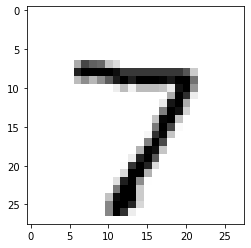

In [49]:
import matplotlib.pyplot as plt
import numpy as np
img = X_val[0]
label = y_val[0]
img = img.reshape(1, 28, 28, 1)
img_predict = model.predict([img], batch_size=None)
img1 = img.reshape(28, 28)
plt.imshow(img1, cmap = 'binary')
print('标签：', np.argmax(label), '模型预测：', np.argmax(img_predict))

In [50]:
label

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [51]:
img_predict[0]

array([2.3922138e-07, 1.1321607e-06, 1.7071079e-05, 3.7490061e-06,
       1.6076132e-07, 4.1216438e-07, 4.8547797e-09, 9.9996066e-01,
       5.9741069e-07, 1.5958376e-05], dtype=float32)

### 2.FGSM非定向攻击 

In [52]:
import tensorflow as tf
loss_object = tf.keras.losses.CategoricalCrossentropy()
# 计算梯度
def compute_grad(input_image, input_label):
    with tf.GradientTape() as g:
        g.watch(tensor=input_image) # 将输入样本作为要计算梯度的变量
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)

    gradient = g.gradient(loss, input_image) # 求损失函数的梯度
    return gradient

In [53]:
label = label.reshape(1,10)

In [54]:
gradients = compute_grad(tf.constant(img), label)

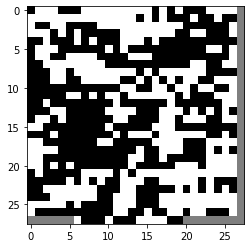

In [55]:
perturbations = tf.sign(gradients) # 梯度的符号作为扰动
plt.imshow(perturbations.numpy().reshape(28, 28), cmap = 'binary')

2


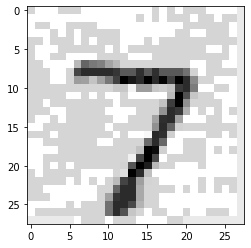

In [56]:
epsilon = 0.1
adv_x = img + epsilon * perturbations.numpy()
img_predict = model.predict([adv_x], batch_size=None)
print(np.argmax(img_predict))
plt.imshow(adv_x.reshape(28, 28), cmap = 'binary')

7


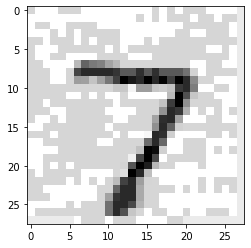

In [57]:
epsilon = 0.098
adv_x = img + epsilon * perturbations.numpy()
img_predict = model.predict([adv_x], batch_size=None)
print(np.argmax(img_predict))
plt.imshow(adv_x.reshape(28, 28), cmap = 'binary')

### 3.FGM定向攻击 

In [58]:
taget_label = np.array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]) # 攻击目标
taget_label = taget_label.reshape(1,10)
e = 0.001
adv = img
for i in range(1000):
    gradients = compute_grad(tf.constant(adv), taget_label)
    adv = adv - e * gradients
    adv_predict = model.predict([adv], batch_size=None)
    print(i, ':', np.argmax(adv_predict), np.max(adv_predict))
    if np.argmax(adv_predict) == np.argmax(taget_label):
        break

0 : 7 0.99995875
1 : 7 0.9999566
2 : 7 0.9999542
3 : 7 0.99995184
4 : 7 0.9999492
5 : 7 0.99994624
6 : 7 0.9999434
7 : 7 0.99994016
8 : 7 0.9999368
9 : 7 0.99993324
10 : 7 0.99992955
11 : 7 0.9999255
12 : 7 0.9999213
13 : 7 0.9999167
14 : 7 0.9999119
15 : 7 0.999907
16 : 7 0.9999018
17 : 7 0.9998965
18 : 7 0.9998909
19 : 7 0.99988484
20 : 7 0.9998784
21 : 7 0.9998716
22 : 7 0.99986446
23 : 7 0.99985695
24 : 7 0.99984896
25 : 7 0.9998405
26 : 7 0.99983156
27 : 7 0.9998222
28 : 7 0.9998122
29 : 7 0.9998018
30 : 7 0.9997912
31 : 7 0.99977964
32 : 7 0.9997675
33 : 7 0.99975485
34 : 7 0.9997415
35 : 7 0.99972767
36 : 7 0.9997131
37 : 7 0.9996977
38 : 7 0.99968195
39 : 7 0.9996654
40 : 7 0.9996475
41 : 7 0.9996289
42 : 7 0.9996093
43 : 7 0.99958843
44 : 7 0.99956614
45 : 7 0.9995426
46 : 7 0.99951816
47 : 7 0.99949324
48 : 7 0.9994667
49 : 7 0.9994392
50 : 7 0.9994112
51 : 7 0.9993812
52 : 7 0.99935097
53 : 7 0.9993185
54 : 7 0.9992834
55 : 7 0.9992467
56 : 7 0.99920803
57 : 7 0.99916744
58 

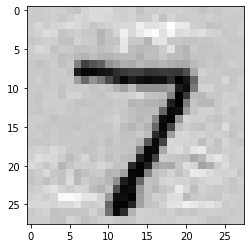

In [59]:
plt.imshow(adv.numpy().reshape(28, 28), cmap = 'binary')

### 4.DeepFool多分类非定向攻击

In [89]:
def deepfool(img, olabel, model, epochs=1000):

    #epochs = 1000 # 最大迭代次数
    overshoot = 0.02 # 加大一点扰动，越过分类超平面

    input_shape = [28, 28, 1]
    w = np.zeros(input_shape)
    r_tot = np.zeros(img.shape) # 记录累积扰动

    orig_label = np.argmax(olabel)
    output = model(img)
    adv = img
    
    one_hot = np.eye(10)

    for epoch in range(epochs):

        scores = model(adv).numpy()[0]
        label = np.argmax(scores)
        print(epoch, ':', label, scores[label])

        if label != orig_label: # 无定向攻击成功
            break

        pert = np.inf

        grad_orig = compute_grad(tf.constant(adv), olabel)

        for k in range(num_classes):

            if k == orig_label:
                continue

            klabel = one_hot[k]
            klabel = klabel.reshape(1,10)
            cur_grad = compute_grad(tf.constant(adv), klabel)

            w_k = cur_grad - grad_orig
            f_k = (output[0, k] - output[0, orig_label]).numpy()

            #if np.linalg.norm(w_k) == 0:
            #    print('norm==0', epoch, k, orig_label)
            pert_k = abs(f_k) / (np.linalg.norm(w_k) + 1e-5)

            if pert_k < pert: # 选择pert最小值
                pert = pert_k
                w = w_k

        # 计算 r_i 和 r_tot
        r_i =  (pert + 1e-8) * w / (np.linalg.norm(w) + 1e-5) # 本次迭代的扰动
        r_tot = r_tot + r_i # 累积扰动
        adv = img + (1 + overshoot) * r_tot # 原样本加上扰动
    
    if epoch == epochs -1:
        succ = False
    else:
        succ = True
    return succ, adv, r_tot, epoch, label

In [90]:
succ, adv, r_tot, epoch, label1 = deepfool(img, label, model)

0 : 7 0.99996066
1 : 7 0.9999734
2 : 7 0.9999827
3 : 7 0.9999883
4 : 7 0.9999919
5 : 7 0.9999943
6 : 7 0.9999957
7 : 7 0.99999666
8 : 7 0.9999975
9 : 7 0.999998
10 : 7 0.9999982
11 : 7 0.99999845
12 : 7 0.99999845
13 : 7 0.99999845
14 : 7 0.99999833
15 : 7 0.99999833
16 : 7 0.99999857
17 : 7 0.99999845
18 : 7 0.99999857
19 : 7 0.99999845
20 : 7 0.9999982
21 : 7 0.99999845
22 : 7 0.99999833
23 : 7 0.99999833
24 : 7 0.9999982
25 : 7 0.999998
26 : 7 0.9999976
27 : 7 0.99999785
28 : 7 0.9999975
29 : 7 0.9999968
30 : 7 0.9999974
31 : 7 0.99999666
32 : 7 0.99999547
33 : 7 0.9999943
34 : 7 0.99999535
35 : 7 0.9999943
36 : 7 0.9999925
37 : 7 0.99999034
38 : 7 0.99999225
39 : 7 0.9999901
40 : 7 0.9999871
41 : 7 0.9999827
42 : 7 0.99998665
43 : 7 0.9999825
44 : 7 0.9999769
45 : 7 0.99996936
46 : 7 0.999961
47 : 7 0.9999478
48 : 7 0.9999578
49 : 7 0.9999448
50 : 7 0.9999267
51 : 7 0.9999031
52 : 7 0.9998646
53 : 7 0.99982363
54 : 7 0.9997757
55 : 7 0.9997131
56 : 7 0.99987876
57 : 7 0.9998385
58 

In [91]:
np.save('r_1_7_8', r_tot)

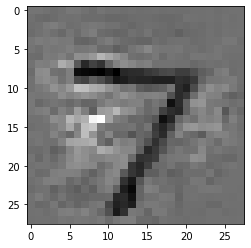

In [92]:
plt.imshow(adv.numpy().reshape(28, 28), cmap = 'binary')

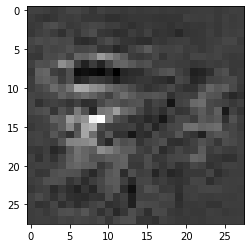

In [93]:
plt.imshow(r_tot.numpy().reshape(28, 28), cmap = 'binary')

### 5.UAP通用对抗样本

In [94]:
def proj_l2(v, xi):
    # 如果v的2范数大于xi，则按比例缩小v
    v = v * min(1, xi/np.linalg.norm(v)) 
    return v

In [95]:
# 时间原因，只取小部分样本进行实验
X_val1 = X_val[:100]

delta = 0.2 # 1-delta为对抗成功率
max_iter = 10 # 最多训练轮数
xi = 10 # 扰动的幅度

fooling_rate = 0.0
n_samples = np.shape(X_val1)[0]

v = 0 # 通用对抗扰动
itr = 0 # 迭代次数
while itr < max_iter:
        
    np.random.shuffle(X_val1) # 打乱顺序
    
    # 遍历所有测试样本，计算通用对抗扰动v
    for k in range(n_samples):
        print('序号：', k, '开始调整扰动...')
        cur_img = X_val1[k].reshape(1, 28, 28, 1)
        cur_label = model(cur_img)
        v_label = model(cur_img + v)
        if np.argmax(cur_label) == np.argmax(v_label): # 如果当前扰动不起作用。。。
            succ, adv, r_tot, epochs, label1 = deepfool(cur_img+v, v_label, model, 600) # 找到到最近分类超平面的向量r_tot
            #print('itr:', itr, 'k:', k, 'succ', succ, 'epochs:', epochs)
            if succ: 
                v = v + r_tot
                v = proj_l2(v, xi) # 限制v的大小

    # 验证通用对抗扰动v的效果
    X_perturbed = X_val1 + v # 所有样本加上扰动
    est_labels_pert = np.argmax( model(X_perturbed), axis=1 ) # 扰动后的标签
    est_labels_orig = np.argmax( model(X_val1), axis=1 ) # 扰动前的标签
    fooling_rate = float(np.sum(est_labels_pert != est_labels_orig) / float(n_samples)) # 计算成功率
    
    if fooling_rate < 1 - delta:
        print('轮次:', itr, '成功率 = ', fooling_rate)
    else:
        print('完成。成功率 = ', fooling_rate)
        break;

    itr += 1

序号： 0 开始调整扰动...
0 : 7 0.9997043
1 : 7 0.9997702
2 : 7 0.99982905
3 : 7 0.9998691
4 : 7 0.9998987
5 : 7 0.9999207
6 : 7 0.9999354
7 : 7 0.9999455
8 : 7 0.9999515
9 : 7 0.9999578
10 : 7 0.9999658
11 : 7 0.99997365
12 : 7 0.99997747
13 : 7 0.9999808
14 : 7 0.99998224
15 : 7 0.99998283
16 : 7 0.9999831
17 : 7 0.99998283
18 : 7 0.99998283
19 : 7 0.99998105
20 : 7 0.9999794
21 : 7 0.99997747
22 : 7 0.9999751
23 : 7 0.99997616
24 : 7 0.9999734
25 : 7 0.9999701
26 : 7 0.9999713
27 : 7 0.9999685
28 : 7 0.9999646
29 : 7 0.9999665
30 : 7 0.99996173
31 : 7 0.999954
32 : 7 0.99995935
33 : 7 0.9999517
34 : 7 0.9999398
35 : 7 0.99994886
36 : 7 0.9999366
37 : 7 0.99991834
38 : 7 0.9998914
39 : 7 0.9999101
40 : 7 0.99988806
41 : 7 0.99985504
42 : 7 0.9998777
43 : 7 0.99984837
44 : 7 0.9998035
45 : 7 0.9998313
46 : 7 0.9997881
47 : 7 0.99972564
48 : 7 0.9997608
49 : 7 0.99970406
50 : 7 0.99962354
51 : 7 0.99967
52 : 7 0.9995914
53 : 7 0.9994842
54 : 7 0.9995432
55 : 7 0.9994319
56 : 7 0.9992849
57 : 7 0

414 : 7 1.0
415 : 7 1.0
416 : 7 1.0
417 : 7 1.0
418 : 7 1.0
419 : 7 1.0
420 : 7 1.0
421 : 7 1.0
422 : 7 1.0
423 : 7 1.0
424 : 7 1.0
425 : 7 1.0
426 : 7 1.0
427 : 7 1.0
428 : 7 1.0
429 : 7 1.0
430 : 7 1.0
431 : 7 1.0
432 : 7 1.0
433 : 7 1.0
434 : 7 1.0
435 : 7 1.0
436 : 7 1.0
437 : 7 1.0
438 : 7 1.0
439 : 7 1.0
440 : 7 1.0
441 : 7 1.0
442 : 7 1.0
443 : 7 1.0
444 : 7 1.0
445 : 7 1.0
446 : 7 1.0
447 : 7 1.0
448 : 7 1.0
449 : 7 1.0
450 : 7 1.0
451 : 7 1.0
452 : 7 1.0
453 : 7 1.0
454 : 7 1.0
455 : 7 1.0
456 : 7 1.0
457 : 7 1.0
458 : 7 1.0
459 : 7 1.0
460 : 7 1.0
461 : 7 1.0
462 : 7 1.0
463 : 7 1.0
464 : 7 1.0
465 : 7 1.0
466 : 7 1.0
467 : 7 1.0
468 : 7 1.0
469 : 7 1.0
470 : 7 1.0
471 : 7 1.0
472 : 7 1.0
473 : 7 1.0
474 : 7 1.0
475 : 7 1.0
476 : 7 1.0
477 : 7 1.0
478 : 7 1.0
479 : 7 1.0
480 : 7 1.0
481 : 7 1.0
482 : 7 1.0
483 : 7 1.0
484 : 7 1.0
485 : 7 1.0
486 : 7 1.0
487 : 7 1.0
488 : 7 1.0
489 : 7 1.0
490 : 7 1.0
491 : 7 1.0
492 : 7 1.0
493 : 7 1.0
494 : 7 1.0
495 : 7 1.0
496 : 7 1.0
497 

500 : 3 1.0
501 : 3 1.0
502 : 3 1.0
503 : 3 1.0
504 : 3 1.0
505 : 3 1.0
506 : 3 1.0
507 : 3 1.0
508 : 3 1.0
509 : 3 1.0
510 : 3 1.0
511 : 3 1.0
512 : 3 1.0
513 : 3 1.0
514 : 3 1.0
515 : 3 1.0
516 : 3 1.0
517 : 3 1.0
518 : 3 1.0
519 : 3 1.0
520 : 3 1.0
521 : 3 1.0
522 : 3 1.0
523 : 3 1.0
524 : 3 1.0
525 : 3 1.0
526 : 3 1.0
527 : 3 1.0
528 : 3 1.0
529 : 3 1.0
530 : 3 1.0
531 : 3 1.0
532 : 3 1.0
533 : 3 1.0
534 : 3 1.0
535 : 3 1.0
536 : 3 1.0
537 : 3 1.0
538 : 3 1.0
539 : 3 1.0
540 : 3 1.0
541 : 3 1.0
542 : 3 1.0
543 : 3 1.0
544 : 3 1.0
545 : 3 1.0
546 : 3 1.0
547 : 3 1.0
548 : 3 1.0
549 : 3 1.0
550 : 3 1.0
551 : 3 1.0
552 : 3 1.0
553 : 3 1.0
554 : 3 1.0
555 : 3 1.0
556 : 3 1.0
557 : 3 1.0
558 : 3 1.0
559 : 3 1.0
560 : 3 1.0
561 : 3 1.0
562 : 3 1.0
563 : 3 1.0
564 : 3 1.0
565 : 3 1.0
566 : 3 1.0
567 : 3 1.0
568 : 3 1.0
569 : 3 1.0
570 : 3 1.0
571 : 3 1.0
572 : 3 1.0
573 : 3 1.0
574 : 3 1.0
575 : 3 1.0
576 : 3 1.0
577 : 3 1.0
578 : 3 1.0
579 : 3 1.0
580 : 3 1.0
581 : 3 1.0
582 : 3 1.0
583 

580 : 3 1.0
581 : 3 1.0
582 : 3 1.0
583 : 3 1.0
584 : 3 1.0
585 : 3 1.0
586 : 3 1.0
587 : 3 1.0
588 : 3 1.0
589 : 3 1.0
590 : 3 1.0
591 : 3 1.0
592 : 3 1.0
593 : 3 1.0
594 : 3 1.0
595 : 3 1.0
596 : 3 1.0
597 : 3 1.0
598 : 3 1.0
599 : 3 1.0
序号： 16 开始调整扰动...
序号： 17 开始调整扰动...
序号： 18 开始调整扰动...
序号： 19 开始调整扰动...
序号： 20 开始调整扰动...
序号： 21 开始调整扰动...
序号： 22 开始调整扰动...
序号： 23 开始调整扰动...
序号： 24 开始调整扰动...
序号： 25 开始调整扰动...
序号： 26 开始调整扰动...
序号： 27 开始调整扰动...
序号： 28 开始调整扰动...
序号： 29 开始调整扰动...
0 : 3 1.0
1 : 3 1.0
2 : 3 1.0
3 : 3 1.0
4 : 3 1.0
5 : 3 1.0
6 : 3 1.0
7 : 3 1.0
8 : 3 1.0
9 : 3 1.0
10 : 3 1.0
11 : 3 1.0
12 : 3 1.0
13 : 3 1.0
14 : 3 1.0
15 : 3 1.0
16 : 3 1.0
17 : 3 1.0
18 : 3 1.0
19 : 3 1.0
20 : 3 1.0
21 : 3 1.0
22 : 3 1.0
23 : 3 1.0
24 : 3 1.0
25 : 3 1.0
26 : 3 1.0
27 : 3 1.0
28 : 3 1.0
29 : 3 1.0
30 : 3 1.0
31 : 3 1.0
32 : 3 1.0
33 : 3 1.0
34 : 3 1.0
35 : 3 1.0
36 : 3 1.0
37 : 3 1.0
38 : 3 1.0
39 : 3 1.0
40 : 3 1.0
41 : 3 1.0
42 : 3 1.0
43 : 3 1.0
44 : 3 1.0
45 : 3 1.0
46 : 3 1.0
47 : 3 1.0
48 :

55 : 3 1.0
56 : 3 1.0
57 : 3 1.0
58 : 3 1.0
59 : 3 1.0
60 : 3 1.0
61 : 3 1.0
62 : 3 1.0
63 : 3 1.0
64 : 3 1.0
65 : 3 1.0
66 : 3 1.0
67 : 3 1.0
68 : 3 1.0
69 : 3 1.0
70 : 3 1.0
71 : 3 1.0
72 : 3 1.0
73 : 3 1.0
74 : 3 1.0
75 : 3 1.0
76 : 3 1.0
77 : 3 1.0
78 : 3 1.0
79 : 3 1.0
80 : 3 1.0
81 : 3 1.0
82 : 3 1.0
83 : 3 1.0
84 : 3 1.0
85 : 3 1.0
86 : 3 1.0
87 : 3 1.0
88 : 3 1.0
89 : 3 1.0
90 : 3 1.0
91 : 3 1.0
92 : 3 1.0
93 : 3 1.0
94 : 3 1.0
95 : 3 1.0
96 : 3 1.0
97 : 3 1.0
98 : 3 1.0
99 : 3 1.0
100 : 3 1.0
101 : 3 1.0
102 : 3 1.0
103 : 3 1.0
104 : 3 1.0
105 : 3 1.0
106 : 3 1.0
107 : 3 1.0
108 : 3 1.0
109 : 3 1.0
110 : 3 1.0
111 : 3 1.0
112 : 3 1.0
113 : 3 1.0
114 : 3 1.0
115 : 3 1.0
116 : 3 1.0
117 : 3 1.0
118 : 3 1.0
119 : 3 1.0
120 : 3 1.0
121 : 3 1.0
122 : 3 1.0
123 : 3 1.0
124 : 3 1.0
125 : 3 1.0
126 : 3 1.0
127 : 3 1.0
128 : 3 1.0
129 : 3 1.0
130 : 3 1.0
131 : 3 1.0
132 : 3 1.0
133 : 3 1.0
134 : 3 1.0
135 : 3 1.0
136 : 3 1.0
137 : 3 1.0
138 : 3 1.0
139 : 3 1.0
140 : 3 1.0
141 : 3 1.0
1

150 : 3 1.0
151 : 3 1.0
152 : 3 1.0
153 : 3 1.0
154 : 3 1.0
155 : 3 1.0
156 : 3 1.0
157 : 3 1.0
158 : 3 1.0
159 : 3 1.0
160 : 3 1.0
161 : 3 1.0
162 : 3 1.0
163 : 3 1.0
164 : 3 1.0
165 : 3 1.0
166 : 3 1.0
167 : 3 1.0
168 : 3 1.0
169 : 3 1.0
170 : 3 1.0
171 : 3 1.0
172 : 3 1.0
173 : 3 1.0
174 : 3 1.0
175 : 3 1.0
176 : 3 1.0
177 : 3 1.0
178 : 3 1.0
179 : 3 1.0
180 : 3 1.0
181 : 3 1.0
182 : 3 1.0
183 : 3 1.0
184 : 3 1.0
185 : 3 1.0
186 : 3 1.0
187 : 3 1.0
188 : 3 1.0
189 : 3 1.0
190 : 3 1.0
191 : 3 1.0
192 : 3 1.0
193 : 3 1.0
194 : 3 1.0
195 : 3 1.0
196 : 3 1.0
197 : 3 1.0
198 : 3 1.0
199 : 3 1.0
200 : 3 1.0
201 : 3 1.0
202 : 3 1.0
203 : 3 1.0
204 : 3 1.0
205 : 3 1.0
206 : 3 1.0
207 : 3 1.0
208 : 3 1.0
209 : 3 1.0
210 : 3 1.0
211 : 3 1.0
212 : 3 1.0
213 : 3 1.0
214 : 3 1.0
215 : 3 1.0
216 : 3 1.0
217 : 3 1.0
218 : 3 1.0
219 : 3 1.0
220 : 3 1.0
221 : 3 1.0
222 : 3 1.0
223 : 3 1.0
224 : 3 1.0
225 : 3 1.0
226 : 3 1.0
227 : 3 1.0
228 : 3 1.0
229 : 3 1.0
230 : 3 1.0
231 : 3 1.0
232 : 3 1.0
233 

242 : 3 1.0
243 : 3 1.0
244 : 3 1.0
245 : 3 1.0
246 : 3 1.0
247 : 3 1.0
248 : 3 1.0
249 : 3 1.0
250 : 3 1.0
251 : 3 1.0
252 : 3 1.0
253 : 3 1.0
254 : 3 1.0
255 : 3 1.0
256 : 3 1.0
257 : 3 1.0
258 : 3 1.0
259 : 3 1.0
260 : 3 1.0
261 : 3 1.0
262 : 3 1.0
263 : 3 1.0
264 : 3 1.0
265 : 3 1.0
266 : 3 1.0
267 : 3 1.0
268 : 3 1.0
269 : 3 1.0
270 : 3 1.0
271 : 3 1.0
272 : 3 1.0
273 : 3 1.0
274 : 3 1.0
275 : 3 1.0
276 : 3 1.0
277 : 3 1.0
278 : 3 1.0
279 : 3 1.0
280 : 3 1.0
281 : 3 1.0
282 : 3 1.0
283 : 3 1.0
284 : 3 1.0
285 : 3 1.0
286 : 3 1.0
287 : 3 1.0
288 : 3 1.0
289 : 3 1.0
290 : 3 1.0
291 : 3 1.0
292 : 3 1.0
293 : 3 1.0
294 : 3 1.0
295 : 3 1.0
296 : 3 1.0
297 : 3 1.0
298 : 3 1.0
299 : 3 1.0
300 : 3 1.0
301 : 3 1.0
302 : 3 1.0
303 : 3 1.0
304 : 3 1.0
305 : 3 1.0
306 : 3 1.0
307 : 3 1.0
308 : 3 1.0
309 : 3 1.0
310 : 3 1.0
311 : 3 1.0
312 : 3 1.0
313 : 3 1.0
314 : 3 1.0
315 : 3 1.0
316 : 3 1.0
317 : 3 1.0
318 : 3 1.0
319 : 3 1.0
320 : 3 1.0
321 : 3 1.0
322 : 3 1.0
323 : 3 1.0
324 : 3 1.0
325 

332 : 3 1.0
333 : 3 1.0
334 : 3 1.0
335 : 3 1.0
336 : 3 1.0
337 : 3 1.0
338 : 3 1.0
339 : 3 1.0
340 : 3 1.0
341 : 3 1.0
342 : 3 1.0
343 : 3 1.0
344 : 3 1.0
345 : 3 1.0
346 : 3 1.0
347 : 3 1.0
348 : 3 1.0
349 : 3 1.0
350 : 3 1.0
351 : 3 1.0
352 : 3 1.0
353 : 3 1.0
354 : 3 1.0
355 : 3 1.0
356 : 3 1.0
357 : 3 1.0
358 : 3 1.0
359 : 3 1.0
360 : 3 1.0
361 : 3 1.0
362 : 3 1.0
363 : 3 1.0
364 : 3 1.0
365 : 3 1.0
366 : 3 1.0
367 : 3 1.0
368 : 3 1.0
369 : 3 1.0
370 : 3 1.0
371 : 3 1.0
372 : 3 1.0
373 : 3 1.0
374 : 3 1.0
375 : 3 1.0
376 : 3 1.0
377 : 3 1.0
378 : 3 1.0
379 : 3 1.0
380 : 3 1.0
381 : 3 1.0
382 : 3 1.0
383 : 3 1.0
384 : 3 1.0
385 : 3 1.0
386 : 3 1.0
387 : 3 1.0
388 : 3 1.0
389 : 3 1.0
390 : 3 1.0
391 : 3 1.0
392 : 3 1.0
393 : 3 1.0
394 : 3 1.0
395 : 3 1.0
396 : 3 1.0
397 : 3 1.0
398 : 3 1.0
399 : 3 1.0
400 : 3 1.0
401 : 3 1.0
402 : 3 1.0
403 : 3 1.0
404 : 3 1.0
405 : 3 1.0
406 : 3 1.0
407 : 3 1.0
408 : 3 1.0
409 : 3 1.0
410 : 3 1.0
411 : 3 1.0
412 : 3 1.0
413 : 3 1.0
414 : 3 1.0
415 

423 : 3 1.0
424 : 3 1.0
425 : 3 1.0
426 : 3 1.0
427 : 3 1.0
428 : 3 1.0
429 : 3 1.0
430 : 3 1.0
431 : 3 1.0
432 : 3 1.0
433 : 3 1.0
434 : 3 1.0
435 : 3 1.0
436 : 3 1.0
437 : 3 1.0
438 : 3 1.0
439 : 3 1.0
440 : 3 1.0
441 : 3 1.0
442 : 3 1.0
443 : 3 1.0
444 : 3 1.0
445 : 3 1.0
446 : 3 1.0
447 : 3 1.0
448 : 3 1.0
449 : 3 1.0
450 : 3 1.0
451 : 3 1.0
452 : 3 1.0
453 : 3 1.0
454 : 3 1.0
455 : 3 1.0
456 : 3 1.0
457 : 3 1.0
458 : 3 1.0
459 : 3 1.0
460 : 3 1.0
461 : 3 1.0
462 : 3 1.0
463 : 3 1.0
464 : 3 1.0
465 : 3 1.0
466 : 3 1.0
467 : 3 1.0
468 : 3 1.0
469 : 3 1.0
470 : 3 1.0
471 : 3 1.0
472 : 3 1.0
473 : 3 1.0
474 : 3 1.0
475 : 3 1.0
476 : 3 1.0
477 : 3 1.0
478 : 3 1.0
479 : 3 1.0
480 : 3 1.0
481 : 3 1.0
482 : 3 1.0
483 : 3 1.0
484 : 3 1.0
485 : 3 1.0
486 : 3 1.0
487 : 3 1.0
488 : 3 1.0
489 : 3 1.0
490 : 3 1.0
491 : 3 1.0
492 : 3 1.0
493 : 3 1.0
494 : 3 1.0
495 : 3 1.0
496 : 3 1.0
497 : 3 1.0
498 : 3 1.0
499 : 3 1.0
500 : 3 1.0
501 : 3 1.0
502 : 3 1.0
503 : 3 1.0
504 : 3 1.0
505 : 3 1.0
506 

324 : 7 0.96890444
325 : 7 0.98007923
326 : 7 0.97416604
327 : 7 0.96632516
328 : 7 0.9781044
329 : 7 0.9716219
330 : 7 0.9630463
331 : 7 0.9760358
332 : 7 0.9689153
333 : 7 0.95950407
334 : 7 0.97358114
335 : 7 0.9656843
336 : 7 0.97780573
337 : 7 0.97120756
338 : 7 0.9625845
339 : 7 0.975858
340 : 7 0.96862745
341 : 7 0.9795807
342 : 7 0.97364974
343 : 7 0.9657757
344 : 7 0.97761476
345 : 7 0.9709725
346 : 7 0.9622253
347 : 7 0.97525656
348 : 7 0.9678789
349 : 7 0.95818394
350 : 7 0.97295594
351 : 7 0.96479666
352 : 7 0.9771061
353 : 7 0.9703525
354 : 7 0.9614454
355 : 7 0.9748371
356 : 7 0.9673525
357 : 7 0.95768774
358 : 7 0.9725576
359 : 7 0.96449065
360 : 7 0.9767849
361 : 7 0.9699744
362 : 7 0.9609641
363 : 7 0.9744434
364 : 7 0.9668282
365 : 7 0.9568911
366 : 7 0.9717578
367 : 7 0.9633716
368 : 7 0.95253897
369 : 7 0.9692833
370 : 7 0.9601638
371 : 7 0.97403663
372 : 7 0.9663922
373 : 7 0.95651317
374 : 7 0.97159284
375 : 7 0.96317965
376 : 7 0.95228696
377 : 7 0.9688811
378 : 

267 : 3 1.0
268 : 3 1.0
269 : 3 1.0
270 : 3 1.0
271 : 3 1.0
272 : 3 1.0
273 : 3 1.0
274 : 3 1.0
275 : 3 1.0
276 : 3 1.0
277 : 3 1.0
278 : 3 1.0
279 : 3 1.0
280 : 3 1.0
281 : 3 1.0
282 : 3 1.0
283 : 3 1.0
284 : 3 1.0
285 : 3 1.0
286 : 3 1.0
287 : 3 1.0
288 : 3 1.0
289 : 3 1.0
290 : 3 1.0
291 : 3 1.0
292 : 3 1.0
293 : 3 1.0
294 : 3 1.0
295 : 3 1.0
296 : 3 1.0
297 : 3 1.0
298 : 3 1.0
299 : 3 1.0
300 : 3 1.0
301 : 3 1.0
302 : 3 1.0
303 : 3 1.0
304 : 3 1.0
305 : 3 1.0
306 : 3 1.0
307 : 3 1.0
308 : 3 1.0
309 : 3 1.0
310 : 3 1.0
311 : 3 1.0
312 : 3 1.0
313 : 3 1.0
314 : 3 1.0
315 : 3 1.0
316 : 3 1.0
317 : 3 1.0
318 : 3 1.0
319 : 3 1.0
320 : 3 1.0
321 : 3 1.0
322 : 3 1.0
323 : 3 1.0
324 : 3 1.0
325 : 3 1.0
326 : 3 1.0
327 : 3 1.0
328 : 3 1.0
329 : 3 1.0
330 : 3 1.0
331 : 3 1.0
332 : 3 1.0
333 : 3 1.0
334 : 3 1.0
335 : 3 1.0
336 : 3 1.0
337 : 3 1.0
338 : 3 1.0
339 : 3 1.0
340 : 3 1.0
341 : 3 1.0
342 : 3 1.0
343 : 3 1.0
344 : 3 1.0
345 : 3 1.0
346 : 3 1.0
347 : 3 1.0
348 : 3 1.0
349 : 3 1.0
350 

325 : 3 1.0
326 : 3 1.0
327 : 3 1.0
328 : 3 1.0
329 : 3 1.0
330 : 3 1.0
331 : 3 1.0
332 : 3 1.0
333 : 3 1.0
334 : 3 1.0
335 : 3 1.0
336 : 3 1.0
337 : 3 1.0
338 : 3 1.0
339 : 3 1.0
340 : 3 1.0
341 : 3 1.0
342 : 3 1.0
343 : 3 1.0
344 : 3 1.0
345 : 3 1.0
346 : 3 1.0
347 : 3 1.0
348 : 3 1.0
349 : 3 1.0
350 : 3 1.0
351 : 3 1.0
352 : 3 1.0
353 : 3 1.0
354 : 3 1.0
355 : 3 1.0
356 : 3 1.0
357 : 3 1.0
358 : 3 1.0
359 : 3 1.0
360 : 3 1.0
361 : 3 1.0
362 : 3 1.0
363 : 3 1.0
364 : 3 1.0
365 : 3 1.0
366 : 3 1.0
367 : 3 1.0
368 : 3 1.0
369 : 3 1.0
370 : 3 1.0
371 : 3 1.0
372 : 3 1.0
373 : 3 1.0
374 : 3 1.0
375 : 3 1.0
376 : 3 1.0
377 : 3 1.0
378 : 3 1.0
379 : 3 1.0
380 : 3 1.0
381 : 3 1.0
382 : 3 1.0
383 : 3 1.0
384 : 3 1.0
385 : 3 1.0
386 : 3 1.0
387 : 3 1.0
388 : 3 1.0
389 : 3 1.0
390 : 3 1.0
391 : 3 1.0
392 : 3 1.0
393 : 3 1.0
394 : 3 1.0
395 : 3 1.0
396 : 3 1.0
397 : 3 1.0
398 : 3 1.0
399 : 3 1.0
400 : 3 1.0
401 : 3 1.0
402 : 3 1.0
403 : 3 1.0
404 : 3 1.0
405 : 3 1.0
406 : 3 1.0
407 : 3 1.0
408 

386 : 3 1.0
387 : 3 1.0
388 : 3 1.0
389 : 3 1.0
390 : 3 1.0
391 : 3 1.0
392 : 3 1.0
393 : 3 1.0
394 : 3 1.0
395 : 3 1.0
396 : 3 1.0
397 : 3 1.0
398 : 3 1.0
399 : 3 1.0
400 : 3 1.0
401 : 3 1.0
402 : 3 1.0
403 : 3 1.0
404 : 3 1.0
405 : 3 1.0
406 : 3 1.0
407 : 3 1.0
408 : 3 1.0
409 : 3 1.0
410 : 3 1.0
411 : 3 1.0
412 : 3 1.0
413 : 3 1.0
414 : 3 1.0
415 : 3 1.0
416 : 3 1.0
417 : 3 1.0
418 : 3 1.0
419 : 3 1.0
420 : 3 1.0
421 : 3 1.0
422 : 3 1.0
423 : 3 1.0
424 : 3 1.0
425 : 3 1.0
426 : 3 1.0
427 : 3 1.0
428 : 3 1.0
429 : 3 1.0
430 : 3 1.0
431 : 3 1.0
432 : 3 1.0
433 : 3 1.0
434 : 3 1.0
435 : 3 1.0
436 : 3 1.0
437 : 3 1.0
438 : 3 1.0
439 : 3 1.0
440 : 3 1.0
441 : 3 1.0
442 : 3 1.0
443 : 3 1.0
444 : 3 1.0
445 : 3 1.0
446 : 3 1.0
447 : 3 1.0
448 : 3 1.0
449 : 3 1.0
450 : 3 1.0
451 : 3 1.0
452 : 3 1.0
453 : 3 1.0
454 : 3 1.0
455 : 3 1.0
456 : 3 1.0
457 : 3 1.0
458 : 3 1.0
459 : 3 1.0
460 : 3 1.0
461 : 3 1.0
462 : 3 1.0
463 : 3 1.0
464 : 3 1.0
465 : 3 1.0
466 : 3 1.0
467 : 3 1.0
468 : 3 1.0
469 

In [96]:
est_labels_pert != est_labels_orig

array([ True, False,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True, False, False, False,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True, False,  True,  True,  True,  True,  True,
       False])

In [97]:
np.save('v',v)

In [98]:
# 看看该扰动在所有测试样本上的成功率
est_labels_pert = np.argmax( model(X_val + v), axis=1 ) # 扰动后的标签
est_labels_orig = np.argmax( model(X_val), axis=1 ) # 扰动前的标签
float(np.sum(est_labels_pert != est_labels_orig) / float(n_samples)) # 计算成功率

85.69

## 第九章对抗样本示例结束